# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Data

In [29]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the project root to the Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.cleaning import merge_and_clean_dataframes

# Load the games data from the parquet file
games_df = pd.read_parquet('../data/games.parquet')

# Load the advanced team game stats from the parquet file
advanced_stats_df = pd.read_parquet('../data/advanced_team_game_stats.parquet')

# Load the team game stats from the parquet file
team_stats_df = pd.read_parquet('../data/team_game_stats.parquet')

# Load the team talent data from the parquet file
team_talent_df = pd.read_parquet('../data/team_talent.parquet')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Join Data

In [32]:
# Use the function to merge and clean the dataframes
merged_df_final = merge_and_clean_dataframes(games_df, team_stats_df, advanced_stats_df, team_talent_df)

# Check the shape of the final dataframe
print("Shape of merged_df_final:", merged_df_final.shape)

df = merged_df_final.copy()

Shape of merged_df_final: (3430, 122)


## Handle Missing Values

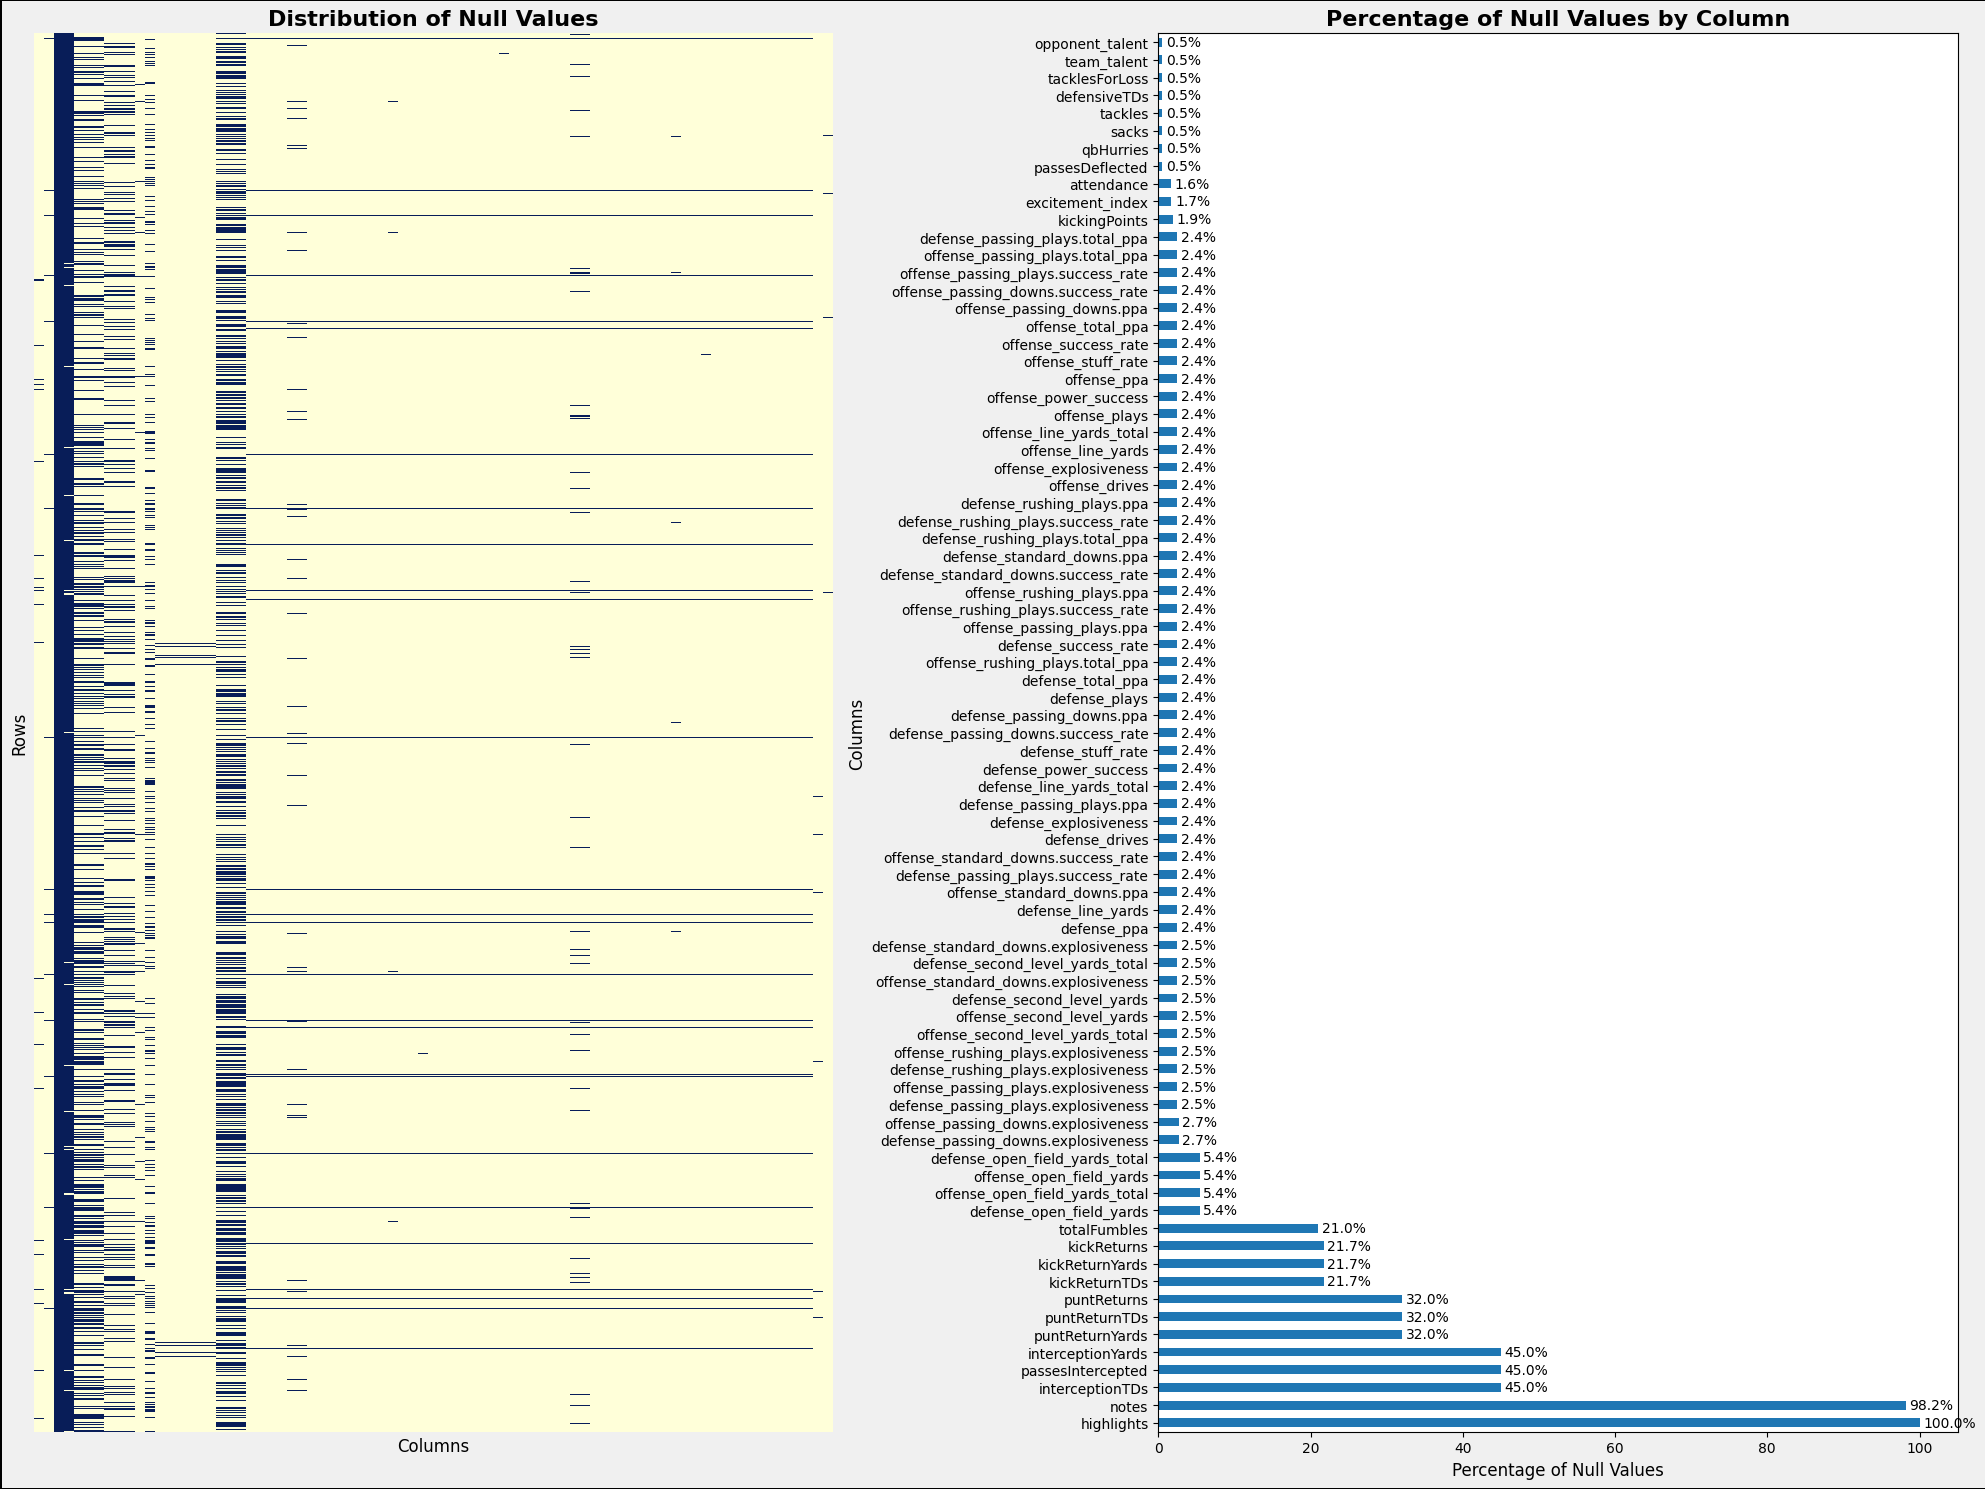

Columns with null values:
attendance: 56 null values (1.63%)
excitement_index: 58 null values (1.69%)
highlights: 3430 null values (100.00%)
notes: 3368 null values (98.19%)
puntReturnYards: 1099 null values (32.04%)
puntReturnTDs: 1099 null values (32.04%)
puntReturns: 1099 null values (32.04%)
kickReturnYards: 745 null values (21.72%)
kickReturnTDs: 745 null values (21.72%)
kickReturns: 745 null values (21.72%)
kickingPoints: 66 null values (1.92%)
totalFumbles: 720 null values (20.99%)
tacklesForLoss: 18 null values (0.52%)
defensiveTDs: 18 null values (0.52%)
tackles: 18 null values (0.52%)
sacks: 18 null values (0.52%)
qbHurries: 18 null values (0.52%)
passesDeflected: 18 null values (0.52%)
interceptionYards: 1543 null values (44.99%)
interceptionTDs: 1543 null values (44.99%)
passesIntercepted: 1543 null values (44.99%)
offense_drives: 84 null values (2.45%)
offense_explosiveness: 84 null values (2.45%)
offense_line_yards: 84 null values (2.45%)
offense_line_yards_total: 84 null

In [42]:
# Check for columns with null values
null_columns = df.columns[df.isnull().any()].tolist()
null_percentages = df[null_columns].isnull().mean().sort_values(ascending=False) * 100

# Create a single figure with two subplots, increasing the height
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

# Set a light grey background for the entire figure
fig.patch.set_facecolor('#f0f0f0')

# Heatmap
sns.heatmap(df[null_columns].isnull(), cmap='YlGnBu', cbar=False, ax=ax1)
ax1.set_title('Distribution of Null Values', fontsize=16, fontweight='bold')
ax1.set_xlabel('Columns', fontsize=12)
ax1.set_ylabel('Rows', fontsize=12)
ax1.set_xticks([])  # Remove x-axis labels
ax1.set_yticks([])  # Remove y-axis labels

# Bar plot
null_percentages.plot(kind='barh', ax=ax2)
ax2.set_title('Percentage of Null Values by Column', fontsize=16, fontweight='bold')
ax2.set_xlabel('Percentage of Null Values', fontsize=12)
ax2.set_ylabel('Columns', fontsize=12)

# Add percentage labels to the bar plot
for i, v in enumerate(null_percentages):
    ax2.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)

# Adjust layout
plt.tight_layout()

# Add a border around the entire figure
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(2)

plt.show()

# Print detailed null value information
print("Columns with null values:")
for col in null_columns:
    null_count = df[col].isnull().sum()
    null_percentage = (null_count / len(df)) * 100
    print(f"{col}: {null_count} null values ({null_percentage:.2f}%)")

## Notes

-   We have a few columns where the vast majority of the values are null.
    -   attendance, home_post_win_prob, home_pregame_elo, home_postgame_elo, away_post_win_prob, away_pregame_elo, away_postgame_elo, excitement_index, highlights, notes
    -   highlights (100%): remove
    -   notes (98%): remove, mostly some minor notes like change of date or what championship game it is. Strange since our initial data pull is supposed to be regular season only.
    -   

In [7]:
# Display a random sample of non-null notes
non_null_notes = games_df[games_df['notes'].notnull()]
if not non_null_notes.empty:
    sample_size = min(5, len(non_null_notes))
    print(f"Random sample of {sample_size} non-null notes:")
    print(non_null_notes[['season', 'week', 'home_team', 'away_team', 'notes']].sample(sample_size))
else:
    print("No non-null notes found in the dataset.")


Random sample of 5 non-null notes:
      season  week       home_team          away_team  \
1563    2022     6             UCF                SMU   
3623    2022    14             TCU       Kansas State   
3441    2022    12  St. Johns (MN)  Northwestern (MN)   
3580    2022    13   New Hampshire            Fordham   
7248    2023    14           Texas     Oklahoma State   

                                        notes  
1563                         Moved from Oct 1  
3623            Dr Pepper Big 12 Championship  
3441  Division III Championship - First Round  
3580           FCS Championship - First Round  
7248            Dr Pepper Big 12 Championship  


Top 10 Games by Home Conference:
home_conference
SEC                            204
Big Ten                        197
ACC                            188
Pennsylvania State Athletic    177
Sun Belt                       171
Big 12                         161
Pac-12                         161
American Athletic              160
Northern Sun                   155
Mountain West                  152
Name: count, dtype: int64

Top 10 Games by Away Conference:
away_conference
Pennsylvania State Athletic    182
CAA                            169
Sun Belt                       167
Northern Sun                   158
Mid-American                   155
ACC                            149
American Athletic              144
Big Ten                        143
Big Sky                        142
Mountain West                  141
Name: count, dtype: int64

Top 10 Games by Home Division:
home_division
iii    2383
ii     1757
fbs    1722
fcs    1363
Name: count, dtype: int64

Top 10 Games by Away Divisio

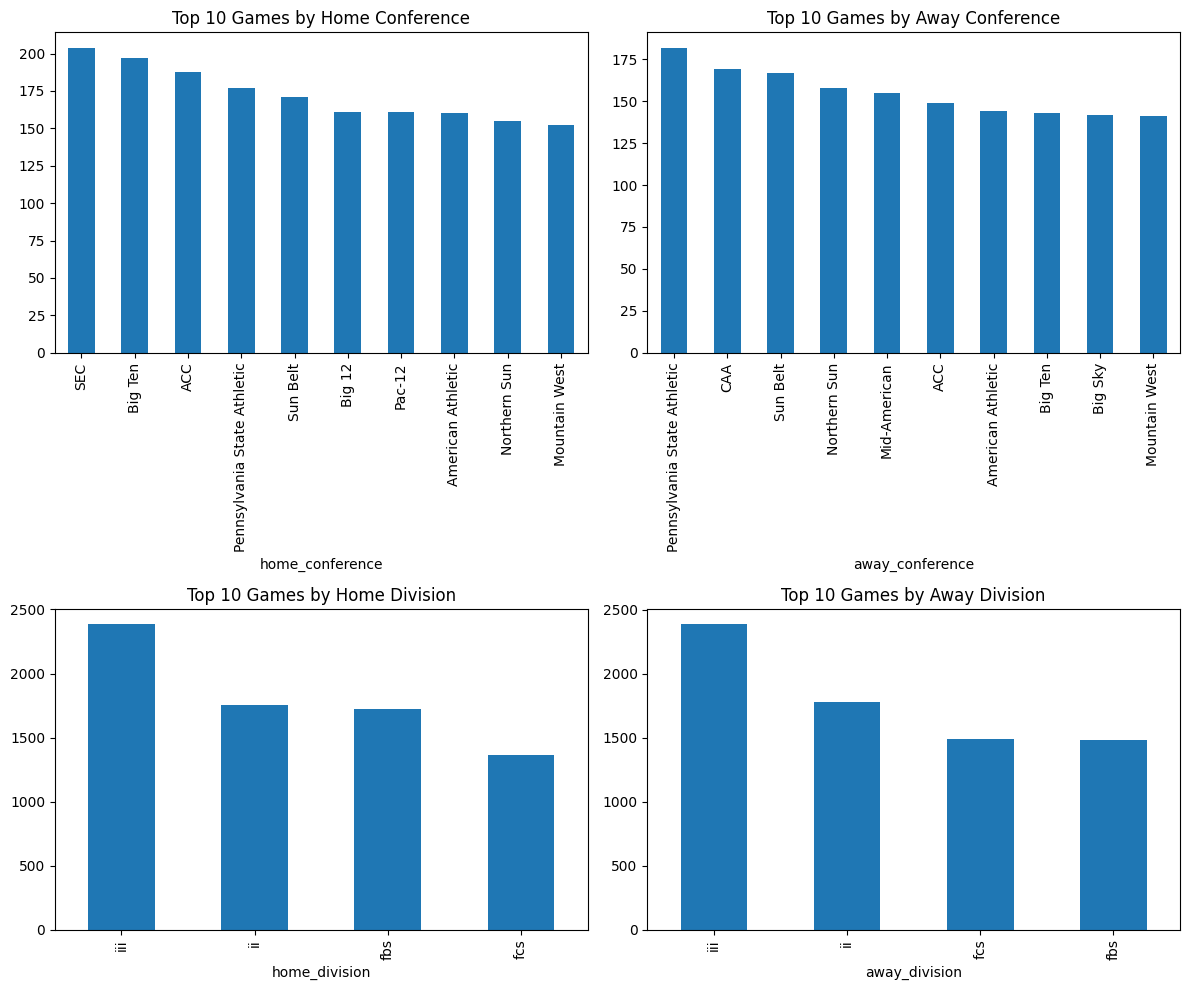

In [14]:
# Count games by conference and division
conference_counts = {
    'home': games_df['home_conference'].value_counts().nlargest(10),
    'away': games_df['away_conference'].value_counts().nlargest(10)
}

division_counts = {
    'home': games_df['home_division'].value_counts().nlargest(10),
    'away': games_df['away_division'].value_counts().nlargest(10)
}

# Display results
print("Top 10 Games by Home Conference:")
print(conference_counts['home'])
print("\nTop 10 Games by Away Conference:")
print(conference_counts['away'])
print("\nTop 10 Games by Home Division:")
print(division_counts['home'])
print("\nTop 10 Games by Away Division:")
print(division_counts['away'])

# Visualize the distribution
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
conference_counts['home'].plot(kind='bar')
plt.title('Top 10 Games by Home Conference')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
conference_counts['away'].plot(kind='bar')
plt.title('Top 10 Games by Away Conference')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
division_counts['home'].plot(kind='bar')
plt.title('Top 10 Games by Home Division')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
division_counts['away'].plot(kind='bar')
plt.title('Top 10 Games by Away Division')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
